# Capstone Business Problem - Week 2

### Applied Data Science Capstone by IBM/Coursera

## Introduction/Business Problem

I am a huge connoisseur of coffee and have always harbored a pipe dream of opening a coffee shop focused on simple, but elevated coffee. The suggested prompt for the assignment got me thinking about where I could open a coffee shop in the city of Atlanta, where I live. Atlanta has some decent coffee, especially within the city limits. However, there are some areas which are devoid of good coffee and therefore could be a good location to open a shop.

Atlanta as a city is vast. The only public transportation runs through the heart of the city, and therefore some of the neighborhoods would only be accessible by car. Therefore, it would be beneficial to cluster neighborhoods to examine locations within the city which have a thriving coffee scene and where similar-minded neighborhoods would fill a need. Therefore, this project will allow me to conduct a city-wide search and find where a hypothetical coffee shop could be located.

Therefore, **my business problem is**: Where is the best place to open a coffee shop in metro Atlanta?


## Atlanta actually provides really nice documentation about all of the 244 official neighborhoods, so I am simply going to use that.

In [2]:
import requests
import pandas as pd
import numpy as np
import geocoder

In [3]:
import math

# Read in CSV
d = pd.read_csv('atl_neighborhoods.csv')[['NAME','SQMILES']]

### Need to add 'GA' for location search
d['NAME'] = d['NAME'] + ', Atlanta, GA'

### Secondly, I want to constrain the Foursquare search to only the neighborhood, so I am computing a customized radius based on the square miles for each neighborhood.

In [4]:
custom_radius = []
for ii in range(len(d)):
    #print(d.loc[ii,'SQMILES'])
    custom_radius.append(math.sqrt(d.loc[ii,'SQMILES']/3.14)*1609) #conversion from miles to meters

d['RADIUS'] = custom_radius

print('The custom radius calculation had a minimum distance of {}m and maximum of {}m'.format(min(d['RADIUS']), max(d['RADIUS'])))

d.head()

The custom radius calculation had a minimum distance of 128.4121797108404m and maximum of 1575.3406071902102m


,NAME,SQMILES,RADIUS
0,"Atlanta University Center, Atlanta, GA",0.52,654.776210
1,"Hunter Hills, Atlanta, GA",0.50,642.060899
2,"Bankhead, Atlanta, GA",0.65,732.062058
3,"English Avenue, Atlanta, GA",0.81,817.210108
4,"Adair Park, Atlanta, GA",0.45,609.112451


### This function takes a neighborhood and, using geocoder, finds the associated latitutde and longitude of the centroid

In [5]:
def get_lat_long(name):
    
    # Returning search for zipcode
    g = geocoder.arcgis(name)
    
    # Latitude
    lati = g.lat
    
    # Longitude
    longi = g.lng
    
    return(lati,longi)

### Add longitude and latitutde to dataframe

In [6]:
lat_lookup = []
lng_lookup = []

for n in d['NAME']:
    lati,longi = get_lat_long(n)
    
    lat_lookup.append(lati)
    lng_lookup.append(longi)
    
d['LATITUDE'] = lat_lookup
d['LONGITUDE'] = lng_lookup
d.head() 

,NAME,SQMILES,RADIUS,LATITUDE,LONGITUDE
0,"Atlanta University Center, Atlanta, GA",0.52,654.776210,33.75092,-84.41234
1,"Hunter Hills, Atlanta, GA",0.50,642.060899,33.75848,-84.43129
2,"Bankhead, Atlanta, GA",0.65,732.062058,33.76827,-84.42642
3,"English Avenue, Atlanta, GA",0.81,817.210108,33.76821,-84.41051
4,"Adair Park, Atlanta, GA",0.45,609.112451,33.72997,-84.41044


### Plotting the locations of the neighborhoods

In [7]:
## Looking at where the locations are
import folium

# create map of New York using latitude and longitude values
map_atl = folium.Map(location=[33.7868002,-84.3970265], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(d['LATITUDE'], d['LONGITUDE'], d['NAME']):
    #label = str(borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=borough,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atl)  
    
map_atl

# Part 2: Data

In doing some research for how others go about finding the best coffee shop location, I came across [this page](https://squareup.com/us/en/townsquare/how-to-find-a-coffee-shop-location). With regards to the the Foursquare API, this point seems most salient:

**2. Neighboring businesses**
"When you’re determining the best location for a coffee shop, neighboring businesses can also affect your profitability — both negatively and positively.

It might be obvious to research other local coffee shops to find out where they are established, but your competitors aren’t limited to other coffee shops. If your coffee shop targets customers looking for a quick breakfast, you should keep your eye on quick breakfast alternatives including smoothie joints, juice bars, bagel places, and even fast food chains. While these businesses are all in different categories, they could all be competing with the products you serve.

Neighboring businesses can also help your coffee shop by complementing your offerings. If your coffee shop has a large study space, it might be smart to open near other businesses or a university. This provides an ideal area for employees or students to come in and get work done before or after hours. If you’re targeting customers who seek a midday caffeine buzz, you may want to look at shopping centers where customers need a pick-me-up while walking around and shopping."

Therefore, I am going to look at data analysis which focuses on the locations, in a way that is similar to the lab praticals already completed. Therefore, for this project I will utilize data from the **100 most relevant venues within my custom radius**.



In [8]:
# Using this function from earlier in the course
def getNearbyVenues(names, latitudes, longitudes, radius):

    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        
        CLIENT_ID = 'XHZAVLMJZPZ1YERWSOQP0RZSG1JTQV24LLJOC3CHJZBFUCWM'
        CLIENT_SECRET = 'FKWRVOLJYEBTMABNFPMRYRJ3JOQLKTDE2JPSZKUGJYHQSAMS'
        VERSION = "20180323"
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            400)
              
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting all the top venues from Atlanta

In [9]:
CLIENT_ID = 'XHZAV########' # your Foursquare ID
CLIENT_SECRET = 'FKWR#######' # your Foursquare Secret
VERSION = '20180604'

In [10]:
LIMIT = 100
atl_venues2 = getNearbyVenues(names = d['NAME'],
                             latitudes = d['LATITUDE'],
                             longitudes = d['LONGITUDE'],
                             radius = d['RADIUS'])

In [11]:
atl_venues2.shape

(3133, 7)

In [12]:
atl_venues2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Busy Bee Cafe,33.754577,-84.414024,Southern / Soul Food Restaurant
1,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Murrell's Cafe,33.754005,-84.409473,Buffet
2,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Mr. Everything,33.754739,-84.416131,Sandwich Place
3,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Johnny M's Pizza Bistro,33.754599,-84.417157,Pizza Place
4,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Spelman College Museum of Fine Art,33.746060,-84.412137,Art Museum


### Next, looking at some exploratry analysis

In [13]:
# getting Counts
counts = atl_venues2.groupby('Neighborhood').count().sort_values('Venue', ascending = False).reset_index()[['Neighborhood','Venue']]
counts.columns = ['Neighborhood','Count']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001620E50E588>]],
      dtype=object)

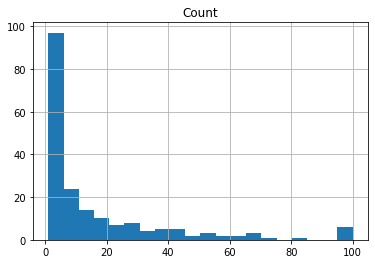

In [14]:
counts.hist(bins=20)

We see a handful of neighborhoods returning less than 10 venues. Those are likely more residential neighborhoods, which are likely not going to be good locations for our coffee shop. Secondly, the *type* of coffee shop is important. My theoreticall coffee shop is not a 'grab-n-go' type place. Therefore, **we will likely require some type of foot traffic** which occurs in areas with more venues. **Therefore, if there are less than 10 locations returned in call, we are not going to include this**.

In [15]:
atl_venues3 = atl_venues2.merge(counts, how = 'left', on = 'Neighborhood')
atl_venues3 = atl_venues3[atl_venues3['Count'] > 10]
atl_venues3.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Count
0,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Busy Bee Cafe,33.754577,-84.414024,Southern / Soul Food Restaurant,20
1,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Murrell's Cafe,33.754005,-84.409473,Buffet,20
2,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Mr. Everything,33.754739,-84.416131,Sandwich Place,20
3,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Johnny M's Pizza Bistro,33.754599,-84.417157,Pizza Place,20
4,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Spelman College Museum of Fine Art,33.746060,-84.412137,Art Museum,20


#### This at least looks a little better

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001620EB8FD08>]],
      dtype=object)

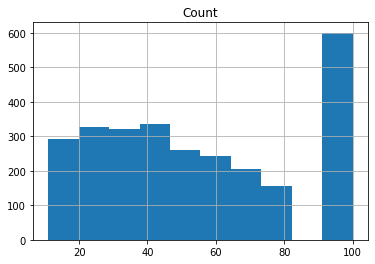

In [16]:
atl_venues3[['Count']].hist()

In [17]:
print('We have reduced our potential neighboorhoods to {} compared to the initial 245'.format(len(atl_venues3['Neighborhood'].unique())))

We have reduced our potential neighboorhoods to 73 compared to the initial 245


#### I'm curious as to where these neighborhoods actually are, so plotting the subset.

In [18]:
new_map = atl_venues3[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].groupby('Neighborhood').mean()
new_map = new_map.reset_index()

In [19]:
new_map_atl = folium.Map(location=[33.7868002,-84.3970265], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(new_map['Neighborhood Latitude'], new_map['Neighborhood Longitude'], new_map['Neighborhood']):
    #label = str(borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=borough,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(new_map_atl)  
    
new_map_atl

### For this analysis, I am clustering the neighborhoods

In [20]:
from sklearn.preprocessing import OneHotEncoder

#### Doing one hot encoding for the different types of venue types

In [21]:
atl_onehot = pd.get_dummies(atl_venues3['Venue Category'], prefix="", prefix_sep="").drop('Neighborhood', axis = 1)
atl_onehot['Neighborhood'] = atl_venues3['Neighborhood']

fixed_columns = [atl_onehot.columns[-1]] + list(atl_onehot.columns[:-1])
atl_onehot = atl_onehot[fixed_columns]

#atl_onehot.head()

In [22]:
# Getting means for each type
atl_grouped = atl_onehot.groupby('Neighborhood').mean().reset_index()
atl_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,...,Volleyball Court,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Adamsville, Atlanta, GA",0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,"Ansley Park, Atlanta, GA",0.000000,0.0,0.0,0.051282,0.0,0.0,0.0,0.0,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,"Arden/Habersham, Atlanta, GA",0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,"Atlanta University Center, Atlanta, GA",0.000000,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.0,0.0
4,"Atlantic Station, Atlanta, GA",0.014493,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.057971,0.0,0.0,0.0


### Want to get a little look at where some of the coffee 'hotspots' are in Atlanta

In [23]:
import matplotlib.pyplot as plt

In [24]:
coffee_map = atl_grouped[['Neighborhood', 'Coffee Shop']]
coffee_map = coffee_map[coffee_map['Coffee Shop'] > 0].sort_values(by = 'Coffee Shop', ascending = False) 

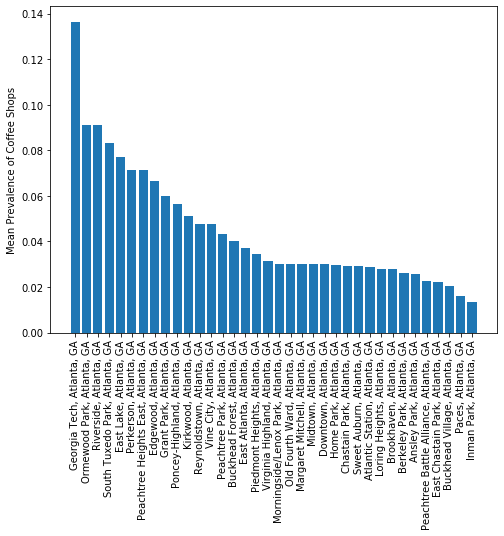

In [25]:
plt.figure(figsize=(8,6))
plt.bar(coffee_map['Neighborhood'],coffee_map['Coffee Shop'])
plt.xticks(rotation=90)
plt.ylabel('Mean Prevalence of Coffee Shops')
plt.show()

### Running Clustering Model

I initially wanted to use Agglomerative Clustering. However, the returned grouping was very homogenous featuring one very large group. K Means clustering appeared to result in a much better distribution of groups.

In [26]:
from sklearn.cluster import KMeans

In [27]:
atl_grouped_km = atl_grouped.drop('Neighborhood', axis = 1)

#### Determining appropriate K using elbow method.

This graph is a little odd, but I am calling the K of 6 as the first elbow.

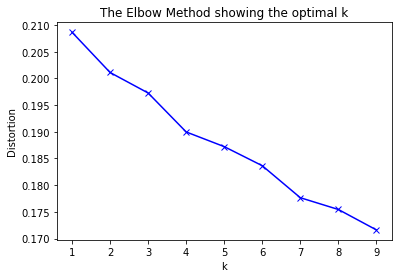

In [28]:
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K_options = range(1,10)
for k in K_options:
    kmeanModel = KMeans(n_clusters=k).fit(atl_grouped_km)
    kmeanModel.fit(atl_grouped_km)
    distortions.append(sum(np.min(cdist(atl_grouped_km, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / atl_grouped_km.shape[0])

# Plot the elbow
plt.plot(K_options, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(atl_grouped_km)

In [30]:
# Adding cluster to data set
atl_grouped['Cluster'] = kmeans.labels_

### Lets see where the groups are within the city of Atlanta.

In [31]:
clust_colors = []
for ii in kmeans.labels_:
    if ii == 0:
       color = 'blue'
    elif ii == 1:
       color = 'red'
    elif ii == 2:
       color = 'green'
    elif ii == 3:
       color = 'orange'
    elif ii == 4:
       color = 'purple'
    else: 
       color = 'grey'
    clust_colors.append(color)
        
new_map['Cluster'] = clust_colors
new_map['Cluster Count'] = kmeans.labels_

In [135]:
# create map of New York using latitude and longitude values
new_map_atl = folium.Map(location=[33.7868002,-84.3970265], zoom_start=12)

# add markers to map
for lat, lng, borough, cluster, num in zip(new_map['Neighborhood Latitude'], new_map['Neighborhood Longitude'], new_map['Neighborhood'], new_map['Cluster'], new_map['Cluster Count']):
    label = str(borough) + ' ' + str(num)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=cluster,
        fill=True,
        fill_color=cluster,
        fill_opacity=0.7,
        parse_html=False).add_to(new_map_atl)  
    
new_map_atl

In [32]:
new_map_atl.save('C:/Users/mattw/Desktop/cluster_atl_map.html')

### Vizualizing the Coffee Frequency Plot with different colors being groups

In [100]:
cluster_coffee_map = atl_grouped[atl_grouped['Coffee Shop'] > 0].sort_values(by = 'Coffee Shop', ascending = False) 

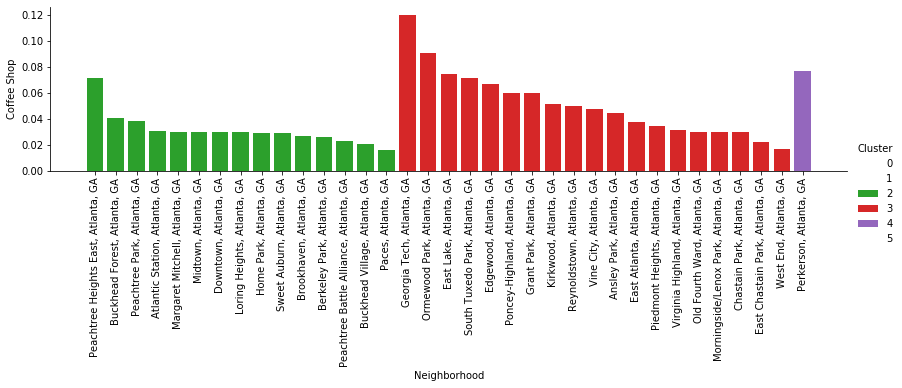

In [102]:
import seaborn

cluster_group = [0,1,2,3,4,5]
fg = seaborn.FacetGrid(data=cluster_coffee_map, hue='Cluster', hue_order=cluster_group, aspect=4)
fg.map(plt.bar, 'Neighborhood', 'Coffee Shop').add_legend()
fg.set_xticklabels(rotation=90)

What is intersting here is that only three clusters contain coffee shops. Perkerson is an interesting one, because it is the only neighborhood in cluster 4 with any coffee shops.

In [105]:
perkerson = atl_venues2[atl_venues2['Neighborhood'] == 'Perkerson, Atlanta, GA']
perkerson

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2829,"Perkerson, Atlanta, GA",33.68924,-84.41169,Rosie's Coffee Cafe,33.692132,-84.418177,Coffee Shop
2830,"Perkerson, Atlanta, GA",33.68924,-84.41169,A Town Wings,33.682283,-84.407460,Wings Joint
2831,"Perkerson, Atlanta, GA",33.68924,-84.41169,Dollar Tree,33.682039,-84.409839,Discount Store
2832,"Perkerson, Atlanta, GA",33.68924,-84.41169,Shell,33.687100,-84.408629,Gas Station
2833,"Perkerson, Atlanta, GA",33.68924,-84.41169,Papa John's Pizza,33.682138,-84.408262,Pizza Place
2834,"Perkerson, Atlanta, GA",33.68924,-84.41169,Foot Locker,33.682259,-84.409267,Shoe Store
2835,"Perkerson, Atlanta, GA",33.68924,-84.41169,The Empty Stocking Fund (Santa's Village),33.692249,-84.406544,Toy / Game Store
2836,"Perkerson, Atlanta, GA",33.68924,-84.41169,American Deli,33.681929,-84.408319,Wings Joint
2837,"Perkerson, Atlanta, GA",33.68924,-84.41169,Rainbow Apparel,33.682577,-84.409967,Clothing Store
2838,"Perkerson, Atlanta, GA",33.68924,-84.41169,Banks Liquor Store,33.695745,-84.408543,Liquor Store


Perkerson does not appear to have many locations which would drive foot traffic. Furthermore, in looking at the map it appears this place is by the highway, reinforcing the 'grab-n-go' nature of the businesses here. I think we can rule out Perkerson as a potential coffee shop location.

*Aside*: as someone with a local knowledge of the city, clusters 2 and 3 make sense. These generally refer to areas with a lot of commerce and are known for good food/drink. We are going to continue with just these clusters. The rationale being no other clusters even feature a coffee shop, which is likely because there is a lack of commerce or foot traffic. I bow to the large conglomerates who have done their market research!

### Since we know Clusters 2 and 3, lets look more cloesly at them.

In [139]:
atl_grouped['Cluster'] = kmeans.labels_

In [141]:
atl_revised = atl_grouped.loc[(atl_grouped['Cluster'] == 2) | (atl_grouped['Cluster'] ==3)]

In [144]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [176]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
atl_top_venues = pd.DataFrame(columns=columns)
atl_top_venues['Neighborhood'] = atl_revised['Neighborhood']

for ind in np.arange(atl_revised.shape[0]-1):
    atl_top_venues.iloc[ind, 1:] = return_most_common_venues(atl_grouped.iloc[ind, :-1], num_top_venues)

atl_top_venues['Cluster'] = atl_grouped['Cluster']

We are going to use this frequency of coffee shops to our advantage. First, because coffee shops are direct competition, if they appear in the top 20 more common venues, that is likely a neighborhood to avoid. Therefore, we are going to look at the presence of coffee shops (and associated businesses such as Cafe, Bakery, and Tea rooms).

In [197]:
coffee_common = []
for ii in range(atl_top_venues.shape[0]):
    present = 0
    for yy in range(1,21):
        if (atl_top_venues.iloc[ii,yy] == 'Coffee Shop') | (atl_top_venues.iloc[ii,yy] == 'Café') | (atl_top_venues.iloc[ii,yy] == 'Tea Room') | (atl_top_venues.iloc[ii,yy] == 'Bakery'):
            present = 1
           
    coffee_common.append(present)
    
    
atl_top_venues['Coffee'] = coffee_common
atl_top_venues.head()        

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Cluster,Coffee
1,"Ansley Park, Atlanta, GA",Discount Store,Fried Chicken Joint,Liquor Store,Fast Food Restaurant,Seafood Restaurant,Food,Chinese Restaurant,Laundromat,Gas Station,...,Falafel Restaurant,Food Court,Food & Drink Shop,Farmers Market,Event Space,Food Service,Flea Market,Flower Shop,3,0
2,"Arden/Habersham, Atlanta, GA",Restaurant,Garden,Park,Coffee Shop,Gym / Fitness Center,Sandwich Place,Theater,American Restaurant,Botanical Garden,...,Museum,Squash Court,Bistro,Food Truck,Miscellaneous Shop,Café,Golf Course,Flower Shop,2,1
3,"Atlanta University Center, Atlanta, GA",Restaurant,Steakhouse,New American Restaurant,Burger Joint,Juice Bar,Lounge,Event Space,Taco Place,Gastropub,...,Museum,Kids Store,Bank,Hotel,Furniture / Home Store,Dessert Shop,Hotel Bar,Shopping Plaza,3,0
4,"Atlantic Station, Atlanta, GA",Pizza Place,Wings Joint,Intersection,Sandwich Place,Buffet,Art Museum,Food Service,Café,Park,...,Fried Chicken Joint,Sports Bar,Eye Doctor,Flower Shop,Food,Flea Market,Food & Drink Shop,Food Court,2,1
5,"Berkeley Park, Atlanta, GA",Clothing Store,Women's Store,American Restaurant,Pizza Place,Shoe Store,Sandwich Place,Coffee Shop,Gym / Fitness Center,Boutique,...,Food Truck,Parking,Men's Store,Fried Chicken Joint,Mobile Phone Shop,Monument / Landmark,Shopping Plaza,Accessories Store,2,1


#### Now, who has the most coffee shops that are common?

In [198]:
atl_top_venues[['Cluster', 'Coffee']].groupby('Cluster').mean()

,Coffee
Cluster,
2,0.772727
3,0.515152


So, it does appear that coffee shops are more common in cluster 2, by 26%. Therefore, for the purposes of this assignment, we are going to look within neighboorhods of Cluster 2, **but focused on those without Coffee Shops**.

In [199]:
cluster3_neighborhoods = atl_top_venues.loc[(atl_top_venues['Cluster'] == 2) & (atl_top_venues['Coffee'] == 0)].drop('Coffee', axis = 1)

print('We have returned {} neighborhoods which are possible locations'.format(cluster3_neighborhoods.shape[0]))

We have returned 5 neighborhoods which are possible locations


From this point forward, it appears to be a little more art than analytics. We want to find a space without many competing venues (e.g., fast food, breakfast) but also has some complementary venues which create foot traffic.

In [200]:
cluster3_neighborhoods

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Cluster
8,"Brookhaven, Atlanta, GA",Gym,Furniture / Home Store,Mexican Restaurant,Rental Car Location,Performing Arts Venue,Gastropub,Brewery,Gourmet Shop,Kitchen Supply Store,...,Arts & Crafts Store,New American Restaurant,Soup Place,Intersection,Mobile Phone Shop,Photography Lab,Food Truck,American Restaurant,Tex-Mex Restaurant,2
11,"Buckhead Village, Atlanta, GA",Mexican Restaurant,Breakfast Spot,Restaurant,Shopping Plaza,New American Restaurant,Gym,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Arts & Crafts Store,...,Middle Eastern Restaurant,Burrito Place,Pool,Pizza Place,Event Space,Flea Market,Flower Shop,Farmers Market,Farm,2
39,"Lenox, Atlanta, GA",Nightclub,Gas Station,Art Gallery,Golf Course,History Museum,Gym / Fitness Center,Furniture / Home Store,BBQ Joint,Athletics & Sports,...,Electronics Store,Discount Store,Strip Club,Southern / Soul Food Restaurant,Intersection,Spa,Dessert Shop,Gay Bar,Farmers Market,2
50,"Paces, Atlanta, GA",Hotel,Chinese Restaurant,Seafood Restaurant,Soccer Field,Discount Store,Restaurant,Thai Restaurant,Fast Food Restaurant,Weight Loss Center,...,Wings Joint,African Restaurant,Pizza Place,Event Space,Ethiopian Restaurant,Exhibit,Zoo Exhibit,Eye Doctor,Falafel Restaurant,2
54,"Peachtree Hills, Atlanta, GA",Gay Bar,Smoke Shop,Furniture / Home Store,Bank,Pet Store,Thrift / Vintage Store,Gym / Fitness Center,Video Store,Breakfast Spot,...,Taco Place,Storage Facility,Steakhouse,Residential Building (Apartment / Condo),Gas Station,Clothing Store,Jewelry Store,Salon / Barbershop,Sandwich Place,2


In [236]:
final_map = cluster3_neighborhoods.merge(new_map, how = 'left', on = 'Neighborhood')

# create map of New York using latitude and longitude values
final_map_atl = folium.Map(location=[33.7868002,-84.3970265], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(final_map['Neighborhood Latitude'], final_map['Neighborhood Longitude'], final_map['Neighborhood']):
    
    if borough == 'Buckhead Village, Atlanta, GA':
        color = 'red'
    elif borough == 'Brookhaven, Atlanta, GA':
        color = 'orange'
    else:
        color = 'blue'
    
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=borough,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map_atl)  
    
final_map_atl

## Discussion

We started this analysis by investigating all 244 neighborhoods in Atlanta for the ideal location to begin a coffee shop. Using the data supplied by the [City of Atlanta](https://dcp-coaplangis.opendata.arcgis.com/), we were able to compute a custom search radius for each neighborhood. Using this, a Foursquare search was completed on all venues within the radius to understand which types of businesses currently operate within those locations. Using an [article posted online](https://squareup.com/us/en/townsquare/how-to-find-a-coffee-shop-location), we were able to distill a few necessary traits for a good coffee shop.

The analysis implemented was aimed at identifying groups of neighborhoods which are conducive to starting a coffee shop. That goal was sucessful, as we identified two main clusters of neighborhoods which featured coffee shops. Furthermore analysis of those shops found that one cluster had a 26% greater rate of coffee shops within the top twenty locations, indicating a greater affinity compared to the other. The goal, then, was to identify neighborhoods within that cluser *but without a prominent coffee scene*. After adding an additional filter (removing like-minded businesses), we returned five possible neighborhoods.

Some of these returned neighborhoods did not fit our *a priori* criteria for an ideal location. For example, Peachtree Hills and Lenox did not feature competing businesses but also did not have venues which supported foot- or car-traffic of our target demographic, people who enjoy good coffee and a relaxing enivronment. Therefore, these two neighborhoods were ruled out.

The winner of our search is: **BUCKHEAD VILLAGE**. I am chosing this because, while there is a popular Breakfast Spot, there is also Shopping Plaza, Gyms, Event Space, other non-competing restaurants, and a Farmer's Market (which would potentially attract individuals who enjoy food and drink). Therefore, while there is some competition for customers, the area is rich enough with traffic *and* the target demographic to be fruitful. The second choice neighborhood (in orange above), **Brookhaven**, featured other food-based but non-competitive businesses. However, the lack of shopping centers, event spaces, etc., made it our second choice. **Paces** was the third-place finisher.

It should be noted this analysis has limitations. Namely, there are other aspects of a good coffee shop location-such as affordable rent, infastructure, adequate parking, etc- which are *very important* components of a successful business but beyond the scope of this project. It is not recommended to open a coffee shop solely sourcing this analysis! Future directions could involve walkability scores, cost of rent for businesses, and investigations of when customers are around the proposed coffee shop location.